In [1]:
import os
import pandas as pd
import networkx as nx
import pickle
import numpy as np
import shutil
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import numpy as np
import glob
from tqdm import tqdm
from pathlib import Path
import json
import random


In [2]:
dataset_path = '/datasets/ricordi'

In [3]:
def data_json(dataset_path):
    dataset = []
    # iterate through all folders in the directory
    for folder in glob.glob(dataset_path + '/*'):
        for files in glob.glob(folder + '/*'):
            # check if the file is either a folder or a json file
            if os.path.isdir(files):
                for data_path in glob.glob(files + '/*'):
                    dataset.append(glob.glob(data_path + '/*.json'))
            elif files.endswith('.json'):
                dataset.append(files)
    dataset = list(flatten(dataset))
    print("Total json files:", len(dataset))
    return dataset

In [4]:
def sort_by_key(data,key):
    dataset = []
    for i in data:
        f = open(i)
        json_data = json.load(f)
        if key in json_data:
            dataset.append(i)
        else:
            continue
    print("Json with annotazione1 present:",len(dataset))
    return dataset

In [5]:
dmerge_classes = [[2, 15], [7, 9]]
classes_relevant = [5,6,7,8,9,10,11,12,14,16]
classes_irrelevant = [0,1,2,3,4,15,17]
classes = classes_relevant + classes_irrelevant

# Define the class names in the same order as the classes list
class_names_relevant = [
    "Pause (full or almost)",
    "Single note (with at least the head)",
    "Multiple Notes (with at least the head)",
    "Single chord (with at least heads)",
    "Multiple chords (with at least heads)",
    "Accidental(s) (whole or nearly so)",
    "Key(s) (whole(s) or nearly)",
    "Embellishment(s) (whole(s) or nearly)",
    "More categories (with at least one musical sign)",
    "Other (with at least one musical sign)"
]

class_names_irrelevant = [
    "Page border",
    "Erasure",
    "Blurr",
    "Printed Text",
    "Manuscript Text",
    "More categories (no musical signs)",
    "Other (without musical markings)"
]

# Combine the relevant and irrelevant class names
class_names = class_names_relevant + class_names_irrelevant

In [6]:
json_list = data_json(dataset_path)
sorted_list_by_key = sort_by_key(json_list, "annotazione1")

Total json files: 469590


Json with annotazione1 present: 196639


In [7]:
def plot_distribution_by_class(sorted_list_by_key, classes, key):
    count = {i: 0 for i in classes}
    
    for i in sorted_list_by_key:
        with open(i) as f:
            json_data = json.load(f)
            class_index = json_data[key]
            count[class_index] += 1
    
    print(count)

    # reorder classes, relevant first
    count = [count[i] for i in classes_relevant] + [count[i] for i in classes_irrelevant]
    labels = ["Relevant"] + [None] * (len(classes_relevant) - 1) + ["Irrelevant"] + [None] * (len(classes_irrelevant) - 1)
    colors = ["tab:red" for _ in classes_relevant] + ["tab:blue" for _ in classes_irrelevant]
    
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    
    x = np.arange(len(classes))  # Generate an array of class indices
    plt.rcParams.update({'font.size': 8})
    plt.bar(x, count, label=labels, color=colors)
    plt.xticks(x, class_names, rotation=45, ha='right')  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.legend()
    plt.show()


{5: 316, 6: 2998, 7: 5621, 8: 975, 9: 818, 10: 2206, 11: 3370, 12: 779, 14: 9039, 16: 1173, 0: 118966, 1: 10370, 2: 13052, 3: 4246, 4: 12501, 15: 1443, 17: 8766}


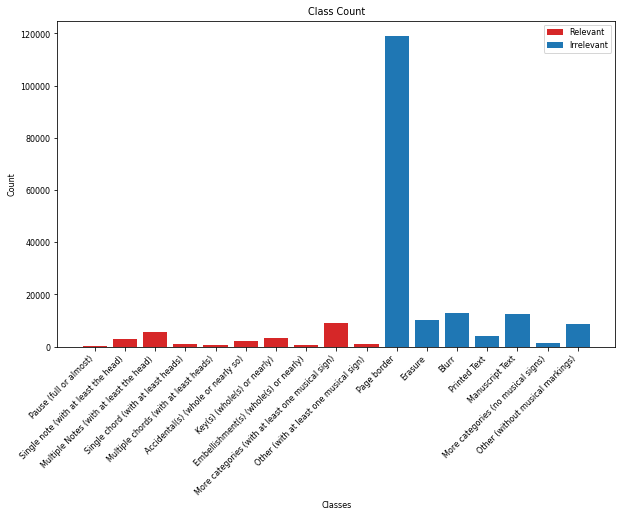

In [8]:
plot_distribution_by_class(sorted_list_by_key,classes, "annotazione1")

In [9]:
from pathlib import Path

binary_dataset_path = Path('./binary_dataset')
relevant_path = binary_dataset_path / 'data' / 'relevant'
irrelevant_path = binary_dataset_path / 'data' / 'irrelevant'
relevant_path.mkdir(exist_ok=True, parents=True)
irrelevant_path.mkdir(exist_ok=True, parents=True)

multiclass_dataset_path = Path('./multiclass_dataset') / 'data'

In [10]:
from shutil import copyfile

# copy all relevant images to both datasets
for json_file in tqdm(Path(dataset_path).glob("**/*.json")):
    with open(json_file, 'r') as f:
        data = json.load(f)
        if "annotazione1" in data:
            label = int(data["annotazione1"])
            png_path = Path(data["path"][18:])
            # compute the name of the physical copy
            if label in classes_irrelevant:
                copied_path = irrelevant_path / png_path.name
            elif label in classes_relevant:
                copied_path = relevant_path / png_path.name
            else:
                print("Unknown label!")
            # copy the file
            copyfile(dataset_path / png_path, copied_path)
            # symlink into the multiclass dataset
            # N.B. handle merged classes
            if label in [9, 7]:
                class_name = "Multiple notes or chords"
            elif label in [15, 2]:
                class_name = "Blurr or multiple categories (no music signs)"
            else:
                class_name = class_names[classes.index(label)]
            class_path = multiclass_dataset_path / class_name
            class_path.mkdir(exist_ok=True, parents=True)
            multiclass_name = (class_path / png_path.name)
            # note relative_to doesn't work for an issue in python 3.9 https://bugs.python.org/issue40358
            target = os.path.relpath(copied_path, start=multiclass_name.parent)
            multiclass_name.symlink_to(target)

0it [00:00, ?it/s]

856it [00:00, 8552.55it/s]

1712it [00:00, 7313.26it/s]

2455it [00:00, 5284.02it/s]

3154it [00:00, 5794.67it/s]

3825it [00:00, 6066.75it/s]

4768it [00:00, 7070.48it/s]

5512it [00:00, 7058.11it/s]

6243it [00:00, 6924.00it/s]

6953it [00:01, 6806.40it/s]

7645it [00:01, 6679.21it/s]

8321it [00:01, 6513.48it/s]

8978it [00:01, 5983.57it/s]

9632it [00:01, 6134.05it/s]

10343it [00:01, 6406.61it/s]

11026it [00:01, 6527.10it/s]

11686it [00:01, 6361.13it/s]

12355it [00:01, 6452.97it/s]

13005it [00:02, 6358.59it/s]

13703it [00:02, 6538.19it/s]

14360it [00:02, 6402.85it/s]

15022it [00:02, 6461.79it/s]

15670it [00:02, 6308.42it/s]

16425it [00:02, 6663.26it/s]

17094it [00:02, 6368.94it/s]

17745it [00:02, 6404.93it/s]

18389it [00:02, 5936.64it/s]

18991it [00:02, 5880.41it/s]

19942it [00:03, 6894.69it/s]

20642it [00:03, 6466.51it/s]

21301it [00:03, 6092.92it/s]

22003it [00:03, 6342.75it/s]

22648it [00:03, 6268.40it/s]

23282it [00:03, 6129.68it/s]

23910it [00:03, 6167.79it/s]

24531it [00:03, 6110.65it/s]

25145it [00:03, 5645.78it/s]

25803it [00:04, 5902.76it/s]

26469it [00:04, 6116.37it/s]

27116it [00:04, 6217.29it/s]

27772it [00:04, 6316.14it/s]

28408it [00:04, 6325.03it/s]

29137it [00:04, 6605.02it/s]

29947it [00:04, 7043.58it/s]

30654it [00:04, 6844.23it/s]

31341it [00:04, 6656.91it/s]

32010it [00:05, 6535.29it/s]

32666it [00:05, 6540.73it/s]

33322it [00:05, 6258.14it/s]

33951it [00:05, 6142.69it/s]

34750it [00:05, 6664.74it/s]

35421it [00:05, 6365.47it/s]

36063it [00:05, 6243.91it/s]

36703it [00:05, 6285.73it/s]

37369it [00:05, 6392.95it/s]

38124it [00:05, 6725.36it/s]

38800it [00:06, 6602.75it/s]

39463it [00:06, 5765.59it/s]

40059it [00:06, 5338.25it/s]

40610it [00:06, 5154.32it/s]

41243it [00:06, 5457.18it/s]

41802it [00:06, 5316.41it/s]

42343it [00:06, 5230.11it/s]

43026it [00:06, 5671.30it/s]

43665it [00:06, 5873.92it/s]

44292it [00:07, 5985.90it/s]

45139it [00:07, 6709.49it/s]

45816it [00:07, 6665.68it/s]

46487it [00:07, 5989.15it/s]

47101it [00:07, 5836.04it/s]

47781it [00:07, 6099.96it/s]

48556it [00:07, 5030.69it/s]

49245it [00:07, 5466.56it/s]

49894it [00:08, 5723.07it/s]

50741it [00:08, 6448.96it/s]

51420it [00:08, 6467.06it/s]

52091it [00:08, 6432.05it/s]

52751it [00:08, 6375.51it/s]

53479it [00:08, 6630.50it/s]

54152it [00:08, 6535.36it/s]

54813it [00:08, 6523.47it/s]

55551it [00:08, 6769.59it/s]

56232it [00:08, 6651.82it/s]

56901it [00:09, 6484.64it/s]

57555it [00:09, 6497.60it/s]

58309it [00:09, 6800.77it/s]

58992it [00:09, 6782.16it/s]

59681it [00:09, 6811.36it/s]

60502it [00:09, 7219.30it/s]

61226it [00:09, 6787.15it/s]

61911it [00:09, 6548.25it/s]

62571it [00:09, 6486.48it/s]

63223it [00:10, 6447.38it/s]

63979it [00:10, 6766.51it/s]

64659it [00:10, 6446.89it/s]

65319it [00:10, 6489.87it/s]

65972it [00:10, 6370.67it/s]

66612it [00:10, 6274.92it/s]

67242it [00:10, 6140.45it/s]

67858it [00:10, 5985.53it/s]

68675it [00:10, 6602.60it/s]

69340it [00:11, 6144.60it/s]

69991it [00:11, 6245.66it/s]

70652it [00:11, 6346.85it/s]

71357it [00:11, 6544.69it/s]

72016it [00:11, 6521.01it/s]

72794it [00:11, 6887.98it/s]

73488it [00:11, 6899.93it/s]

74181it [00:11, 6683.72it/s]

74853it [00:11, 6409.13it/s]

75578it [00:11, 6647.81it/s]

76247it [00:12, 6520.92it/s]

76902it [00:12, 6143.50it/s]

77522it [00:12, 6042.71it/s]

78146it [00:12, 6096.59it/s]

78759it [00:12, 6093.06it/s]

79484it [00:12, 6424.07it/s]

80154it [00:12, 6500.58it/s]

80806it [00:12, 6234.85it/s]

81433it [00:12, 6139.88it/s]

82050it [00:13, 6019.08it/s]

82816it [00:13, 6484.40it/s]

83468it [00:13, 6411.37it/s]

84112it [00:13, 6280.34it/s]

84742it [00:13, 6145.33it/s]

85467it [00:13, 6462.21it/s]

86134it [00:13, 6513.38it/s]

86788it [00:13, 6510.46it/s]

87509it [00:13, 6714.57it/s]

88182it [00:13, 6538.71it/s]

88887it [00:14, 6686.52it/s]

89558it [00:14, 6476.17it/s]

90331it [00:14, 6837.82it/s]

91018it [00:14, 6700.07it/s]

91691it [00:14, 6637.10it/s]

92357it [00:14, 6573.49it/s]

93016it [00:14, 6534.26it/s]

93754it [00:14, 6776.78it/s]

94433it [00:14, 6632.38it/s]

95098it [00:15, 4677.32it/s]

95878it [00:15, 5382.59it/s]

96515it [00:15, 5620.89it/s]

97168it [00:15, 5854.47it/s]

97814it [00:15, 6016.53it/s]

98450it [00:15, 6092.61it/s]

99084it [00:15, 5956.61it/s]

99697it [00:15, 5795.14it/s]

100320it [00:15, 5916.52it/s]

101039it [00:16, 6275.53it/s]

101676it [00:16, 6297.11it/s]

102312it [00:16, 6184.18it/s]

102961it [00:16, 6271.00it/s]

103796it [00:16, 6877.22it/s]

104488it [00:16, 6711.30it/s]

105163it [00:16, 4829.63it/s]

105722it [00:16, 4925.64it/s]

106270it [00:17, 4007.37it/s]

106733it [00:17, 3476.43it/s]

107131it [00:17, 3093.05it/s]

107477it [00:17, 2911.15it/s]

107792it [00:17, 2876.42it/s]

108096it [00:17, 2755.51it/s]

108381it [00:17, 2635.39it/s]

108650it [00:18, 2535.05it/s]

108907it [00:18, 2512.10it/s]

109169it [00:18, 2539.14it/s]

109447it [00:18, 2598.99it/s]

109709it [00:18, 2552.91it/s]

109966it [00:18, 2439.40it/s]

110223it [00:18, 2474.64it/s]

110497it [00:18, 2548.68it/s]

110754it [00:18, 2500.52it/s]

111006it [00:19, 2502.59it/s]

111257it [00:19, 2449.53it/s]

111503it [00:19, 2438.62it/s]

111764it [00:19, 2483.88it/s]

112013it [00:19, 2318.78it/s]

112248it [00:19, 2285.76it/s]

112629it [00:19, 2716.53it/s]

112905it [00:19, 2601.18it/s]

113169it [00:19, 2547.63it/s]

113427it [00:20, 2434.20it/s]

113673it [00:20, 2272.46it/s]

113922it [00:20, 2326.43it/s]

114178it [00:20, 2385.39it/s]

114446it [00:20, 2464.22it/s]

114695it [00:20, 2463.43it/s]

114943it [00:20, 2419.66it/s]

115329it [00:20, 2835.75it/s]

115615it [00:20, 2791.86it/s]

115896it [00:20, 2679.52it/s]

116166it [00:21, 2536.36it/s]

116423it [00:21, 2522.89it/s]

116677it [00:21, 2520.62it/s]

116931it [00:21, 2441.85it/s]

117369it [00:21, 2991.25it/s]

117673it [00:21, 2894.36it/s]

117966it [00:21, 2762.92it/s]

118246it [00:21, 2550.92it/s]

118506it [00:21, 2544.04it/s]

118766it [00:22, 2559.39it/s]

119025it [00:22, 2548.77it/s]

119282it [00:22, 2518.40it/s]

119614it [00:22, 2742.04it/s]

119890it [00:22, 2572.42it/s]

120151it [00:22, 2563.13it/s]

120410it [00:22, 2531.72it/s]

120682it [00:22, 2580.17it/s]

120942it [00:22, 2570.20it/s]

121200it [00:23, 2411.75it/s]

121557it [00:23, 2736.06it/s]

121835it [00:23, 2515.40it/s]

122093it [00:23, 2446.58it/s]

122342it [00:23, 2415.06it/s]

122587it [00:23, 2380.39it/s]

122834it [00:23, 2403.55it/s]

123076it [00:23, 2263.65it/s]

123321it [00:23, 2313.11it/s]

123571it [00:24, 2362.71it/s]

123809it [00:24, 2198.45it/s]

124042it [00:24, 2232.19it/s]

124296it [00:24, 2319.17it/s]

124537it [00:24, 2341.63it/s]

124823it [00:24, 2487.94it/s]

125102it [00:24, 2572.66it/s]

125361it [00:24, 2534.80it/s]

125793it [00:24, 3050.82it/s]

126100it [00:24, 2840.83it/s]

126388it [00:25, 2685.44it/s]

126661it [00:25, 2696.89it/s]

126934it [00:25, 2653.19it/s]

127202it [00:25, 2552.40it/s]

127459it [00:25, 2476.95it/s]

127713it [00:25, 2492.21it/s]

127964it [00:25, 2465.82it/s]

128212it [00:25, 2384.30it/s]

128452it [00:25, 2295.84it/s]

128683it [00:26, 2155.30it/s]

128901it [00:26, 2154.21it/s]

129118it [00:26, 2122.30it/s]

129335it [00:26, 2130.11it/s]

129611it [00:26, 2310.53it/s]

130044it [00:26, 2895.17it/s]

130337it [00:26, 2630.74it/s]

130607it [00:26, 2621.68it/s]

130882it [00:26, 2656.62it/s]

131151it [00:27, 2581.97it/s]

131412it [00:27, 2520.97it/s]

131666it [00:27, 2458.94it/s]

131946it [00:27, 2549.33it/s]

132214it [00:27, 2583.73it/s]

132557it [00:27, 2829.33it/s]

132870it [00:27, 2911.32it/s]

133163it [00:27, 2670.72it/s]

133447it [00:27, 2712.76it/s]

133722it [00:28, 2649.77it/s]

133990it [00:28, 2527.37it/s]

134246it [00:28, 2404.90it/s]

134505it [00:28, 2450.12it/s]

134753it [00:28, 2434.78it/s]

135170it [00:28, 2920.50it/s]

135466it [00:28, 2666.18it/s]

135739it [00:28, 2677.01it/s]

136012it [00:28, 2612.49it/s]

136277it [00:29, 2615.36it/s]

136541it [00:29, 2548.16it/s]

136810it [00:29, 2587.15it/s]

137071it [00:29, 2549.84it/s]

137327it [00:29, 2539.61it/s]

137582it [00:29, 2467.56it/s]

137832it [00:29, 2472.35it/s]

138092it [00:29, 2508.70it/s]

138474it [00:29, 2892.85it/s]

139002it [00:29, 3590.32it/s]

139363it [00:30, 3088.47it/s]

139686it [00:30, 2787.78it/s]

139979it [00:30, 2673.67it/s]

140256it [00:30, 2560.10it/s]

140519it [00:30, 2540.76it/s]

140778it [00:30, 2535.05it/s]

141035it [00:30, 2465.01it/s]

141284it [00:30, 2333.21it/s]

141520it [00:31, 1611.81it/s]

141771it [00:31, 1798.74it/s]

142042it [00:31, 2008.51it/s]

142498it [00:31, 2638.72it/s]

142798it [00:31, 2729.56it/s]

143095it [00:31, 2564.01it/s]

143370it [00:31, 2573.98it/s]

143641it [00:31, 2523.37it/s]

143920it [00:32, 2594.69it/s]

144187it [00:32, 2615.47it/s]

144454it [00:32, 2561.43it/s]

144751it [00:32, 2671.78it/s]

145022it [00:32, 2600.19it/s]

145285it [00:32, 2535.21it/s]

145686it [00:32, 2951.23it/s]

145985it [00:32, 2832.19it/s]

146272it [00:32, 2822.42it/s]

146557it [00:33, 2622.87it/s]

146824it [00:33, 2544.71it/s]

147082it [00:33, 2517.91it/s]

147336it [00:33, 2434.02it/s]

147581it [00:33, 2422.32it/s]

147845it [00:33, 2482.83it/s]

148430it [00:33, 3450.59it/s]

148780it [00:33, 3126.90it/s]

149102it [00:33, 2944.17it/s]

149404it [00:34, 2799.86it/s]

149690it [00:34, 2771.75it/s]

149971it [00:34, 2613.98it/s]

150236it [00:34, 2498.45it/s]

150489it [00:34, 2437.17it/s]

150735it [00:34, 2314.53it/s]

150972it [00:34, 2324.90it/s]

151206it [00:34, 2206.47it/s]

151432it [00:34, 2217.93it/s]

151693it [00:35, 2326.05it/s]

151961it [00:35, 2421.86it/s]

152214it [00:35, 2451.59it/s]

152474it [00:35, 2493.28it/s]

152725it [00:35, 2437.32it/s]

152985it [00:35, 2482.04it/s]

153234it [00:35, 2483.70it/s]

153494it [00:35, 2515.80it/s]

153746it [00:35, 2442.61it/s]

153991it [00:35, 2433.84it/s]

154235it [00:36, 2315.36it/s]

154468it [00:36, 2311.96it/s]

154810it [00:36, 2626.24it/s]

155075it [00:36, 2553.21it/s]

155332it [00:36, 2531.40it/s]

155587it [00:36, 2524.68it/s]

155842it [00:36, 2526.21it/s]

156096it [00:36, 2507.18it/s]

156348it [00:36, 2509.53it/s]

156600it [00:37, 2504.06it/s]

156858it [00:37, 2525.38it/s]

157111it [00:37, 2489.62it/s]

157464it [00:37, 2785.78it/s]

157743it [00:37, 2585.65it/s]

158007it [00:37, 2597.38it/s]

158269it [00:37, 2478.35it/s]

158520it [00:37, 2320.71it/s]

158770it [00:37, 2364.36it/s]

159022it [00:37, 2405.16it/s]

159298it [00:38, 2504.10it/s]

159567it [00:38, 2554.96it/s]

159825it [00:38, 2514.81it/s]

160116it [00:38, 2626.79it/s]

160380it [00:38, 2530.93it/s]

160635it [00:38, 2528.43it/s]

161069it [00:38, 3053.70it/s]

161377it [00:38, 2858.18it/s]

161667it [00:38, 2743.54it/s]

161951it [00:39, 2763.31it/s]

162230it [00:39, 2673.40it/s]

162506it [00:39, 2691.91it/s]

162777it [00:39, 2550.66it/s]

163065it [00:39, 2638.13it/s]

163331it [00:39, 2541.17it/s]

163587it [00:39, 2513.00it/s]

163840it [00:39, 2489.00it/s]

164090it [00:39, 2438.46it/s]

164335it [00:40, 2438.36it/s]

164590it [00:40, 2468.60it/s]

164839it [00:40, 2474.57it/s]

165118it [00:40, 2561.25it/s]

165531it [00:40, 3024.89it/s]

165936it [00:40, 3329.09it/s]

166270it [00:40, 2859.80it/s]

166569it [00:40, 2709.96it/s]

166850it [00:40, 2573.84it/s]

167119it [00:41, 2598.68it/s]

167384it [00:41, 2442.09it/s]

167633it [00:41, 2415.57it/s]

167878it [00:41, 2389.82it/s]

168135it [00:41, 2439.53it/s]

168403it [00:41, 2505.20it/s]

168656it [00:41, 2494.98it/s]

168913it [00:41, 2513.40it/s]

169166it [00:41, 2472.61it/s]

169414it [00:41, 2462.44it/s]

169661it [00:42, 2458.86it/s]

169908it [00:42, 2459.64it/s]

170156it [00:42, 2460.52it/s]

170403it [00:42, 2326.04it/s]

170651it [00:42, 2369.88it/s]

170890it [00:42, 2365.63it/s]

171128it [00:42, 2363.92it/s]

171383it [00:42, 2413.99it/s]

171911it [00:42, 3260.08it/s]

172239it [00:43, 2916.48it/s]

172539it [00:43, 2642.46it/s]

172813it [00:43, 2602.61it/s]

173080it [00:43, 2588.23it/s]

173350it [00:43, 2615.43it/s]

173615it [00:43, 2536.42it/s]

173874it [00:43, 2550.16it/s]

174131it [00:43, 2541.43it/s]

174387it [00:43, 2480.80it/s]

174640it [00:44, 2490.29it/s]

174890it [00:44, 2292.84it/s]

175141it [00:44, 2347.34it/s]

175395it [00:44, 2395.72it/s]

175637it [00:44, 2362.84it/s]

175875it [00:44, 2326.03it/s]

176109it [00:44, 2308.67it/s]

176588it [00:44, 3025.90it/s]

176894it [00:44, 2747.63it/s]

177176it [00:45, 2394.91it/s]

177437it [00:45, 2445.27it/s]

177691it [00:45, 2463.38it/s]

177944it [00:45, 2404.71it/s]

178206it [00:45, 2463.42it/s]

178488it [00:45, 2560.74it/s]

178755it [00:45, 2590.96it/s]

179017it [00:45, 2570.38it/s]

179277it [00:45, 2577.04it/s]

179536it [00:46, 2371.20it/s]

179789it [00:46, 2409.90it/s]

180051it [00:46, 2468.96it/s]

180301it [00:46, 2439.98it/s]

180644it [00:46, 2719.59it/s]

180919it [00:46, 2683.18it/s]

181194it [00:46, 2697.37it/s]

181465it [00:46, 2563.57it/s]

181730it [00:46, 2583.44it/s]

181990it [00:46, 2538.94it/s]

182248it [00:47, 2547.80it/s]

182644it [00:47, 2954.22it/s]

182942it [00:47, 2729.26it/s]

183220it [00:47, 2652.00it/s]

183489it [00:47, 2642.77it/s]

183756it [00:47, 2551.61it/s]

184013it [00:47, 2552.30it/s]

184270it [00:47, 2465.71it/s]

184543it [00:47, 2540.23it/s]

184799it [00:48, 2492.05it/s]

185050it [00:48, 2370.40it/s]

185289it [00:48, 2270.29it/s]

185518it [00:48, 2238.02it/s]

185748it [00:48, 2250.29it/s]

185976it [00:48, 2254.17it/s]

186407it [00:48, 2844.43it/s]

186694it [00:48, 2728.31it/s]

186970it [00:48, 2687.84it/s]

187241it [00:48, 2685.66it/s]

187511it [00:49, 2655.77it/s]

187778it [00:49, 2564.48it/s]

188036it [00:49, 2439.39it/s]

188284it [00:49, 2449.05it/s]

188531it [00:49, 2441.67it/s]

188786it [00:49, 2472.77it/s]

189034it [00:49, 2397.31it/s]

189275it [00:49, 2362.41it/s]

189589it [00:49, 2583.96it/s]

189975it [00:50, 2952.99it/s]

190273it [00:50, 2738.55it/s]

190552it [00:50, 2668.75it/s]

190822it [00:50, 2633.52it/s]

191088it [00:50, 2541.41it/s]

191344it [00:50, 2510.62it/s]

191597it [00:50, 2487.59it/s]

191849it [00:50, 2496.36it/s]

192100it [00:50, 2413.31it/s]

192343it [00:51, 2391.22it/s]

192605it [00:51, 2454.97it/s]

192880it [00:51, 2534.97it/s]

193142it [00:51, 2559.35it/s]

193399it [00:51, 2483.58it/s]

193867it [00:51, 3120.33it/s]

194182it [00:51, 3037.87it/s]

194489it [00:51, 2912.74it/s]

194783it [00:51, 2717.41it/s]

195059it [00:52, 2606.90it/s]

195329it [00:52, 2626.46it/s]

195594it [00:52, 2455.58it/s]

195843it [00:52, 2451.34it/s]

196091it [00:52, 1501.06it/s]

196370it [00:52, 1751.70it/s]

196639it [00:52, 1954.84it/s]

196908it [00:52, 2126.14it/s]

197153it [00:53, 2160.76it/s]

197392it [00:53, 2217.32it/s]

197631it [00:53, 2236.71it/s]

197868it [00:53, 2272.27it/s]

198106it [00:53, 2299.06it/s]

198372it [00:53, 2401.25it/s]

198768it [00:53, 2854.84it/s]

199059it [00:53, 2762.54it/s]

199340it [00:53, 2718.88it/s]

199616it [00:54, 2727.25it/s]

199891it [00:54, 2720.49it/s]

200165it [00:54, 2691.11it/s]

200436it [00:54, 2574.13it/s]

200695it [00:54, 2538.98it/s]

201190it [00:54, 3224.07it/s]

201517it [00:54, 2951.00it/s]

201819it [00:54, 2753.69it/s]

202101it [00:54, 2632.35it/s]

202369it [00:55, 2606.32it/s]

202633it [00:55, 2476.93it/s]

202884it [00:55, 2480.68it/s]

203134it [00:55, 2398.25it/s]

203598it [00:55, 3012.96it/s]

203906it [00:55, 2735.89it/s]

204188it [00:55, 2671.32it/s]

204461it [00:55, 2586.42it/s]

204732it [00:55, 2615.43it/s]

204997it [00:56, 2384.44it/s]

205241it [00:56, 2338.93it/s]

205479it [00:56, 2327.21it/s]

205714it [00:56, 2295.21it/s]

205945it [00:56, 2296.80it/s]

206283it [00:56, 2602.50it/s]

206546it [00:56, 2554.96it/s]

206806it [00:56, 2564.41it/s]

207083it [00:56, 2618.66it/s]

207346it [00:56, 2619.37it/s]

207609it [00:57, 2481.04it/s]

207859it [00:57, 2477.73it/s]

208110it [00:57, 2483.78it/s]

208360it [00:57, 2452.23it/s]

208789it [00:57, 2981.81it/s]

209090it [00:57, 2797.03it/s]

209374it [00:57, 2705.34it/s]

209648it [00:57, 2709.09it/s]

209921it [00:57, 2612.62it/s]

210184it [00:58, 2488.28it/s]

210435it [00:58, 2417.60it/s]

210685it [00:58, 2436.58it/s]

210930it [00:58, 2406.18it/s]

211172it [00:58, 2264.03it/s]

211489it [00:58, 2507.26it/s]

211743it [00:58, 2414.75it/s]

211987it [00:58, 2235.27it/s]

212215it [00:58, 2170.47it/s]

212447it [00:59, 2207.14it/s]

212676it [00:59, 2226.91it/s]

213222it [00:59, 3143.95it/s]

213543it [00:59, 2911.24it/s]

213842it [00:59, 2641.74it/s]

214115it [00:59, 2647.69it/s]

214386it [00:59, 2626.45it/s]

214658it [00:59, 2650.10it/s]

214999it [00:59, 2864.34it/s]

215430it [01:00, 3276.78it/s]

215762it [01:00, 2943.14it/s]

216066it [01:00, 2855.91it/s]

216358it [01:00, 2718.73it/s]

216635it [01:00, 2584.02it/s]

217104it [01:00, 3139.13it/s]

217428it [01:00, 2959.00it/s]

217732it [01:00, 2769.15it/s]

218016it [01:01, 2673.85it/s]

218288it [01:01, 2660.99it/s]

218558it [01:01, 2617.12it/s]

218822it [01:01, 2574.36it/s]

219081it [01:01, 2540.49it/s]

219336it [01:01, 2343.34it/s]

219586it [01:01, 2383.92it/s]

219836it [01:01, 2411.55it/s]

220079it [01:01, 2397.42it/s]

220320it [01:02, 2319.58it/s]

220799it [01:02, 3018.16it/s]

221106it [01:02, 2813.21it/s]

221393it [01:02, 2629.47it/s]

221662it [01:02, 2496.37it/s]

221916it [01:02, 2355.41it/s]

222173it [01:02, 2410.00it/s]

222418it [01:02, 2380.73it/s]

222662it [01:02, 2397.07it/s]

222904it [01:03, 2386.73it/s]

223181it [01:03, 2493.35it/s]

223439it [01:03, 2516.86it/s]

223718it [01:03, 2591.82it/s]

224099it [01:03, 2945.45it/s]

224395it [01:03, 2669.68it/s]

224668it [01:03, 2610.71it/s]

224933it [01:03, 2578.84it/s]

225194it [01:03, 2561.76it/s]

225465it [01:03, 2595.91it/s]

225767it [01:04, 2717.71it/s]

226041it [01:04, 2711.96it/s]

226314it [01:04, 2585.27it/s]

226575it [01:04, 2588.71it/s]

226836it [01:04, 2523.86it/s]

227225it [01:04, 2913.24it/s]

227519it [01:04, 2737.91it/s]

227797it [01:04, 2661.21it/s]

228066it [01:04, 2589.63it/s]

228327it [01:05, 2579.53it/s]

228793it [01:05, 3167.64it/s]

229114it [01:05, 2940.85it/s]

229414it [01:05, 2834.68it/s]

229702it [01:05, 2698.96it/s]

229976it [01:05, 2634.22it/s]

230246it [01:05, 2648.34it/s]

230533it [01:05, 2710.48it/s]

230806it [01:05, 2658.57it/s]

231074it [01:06, 2613.63it/s]

231360it [01:06, 2683.93it/s]

231648it [01:06, 2738.62it/s]

232020it [01:06, 3024.36it/s]

232324it [01:06, 2820.37it/s]

232610it [01:06, 2701.82it/s]

232884it [01:06, 2655.95it/s]

233152it [01:06, 2608.98it/s]

233424it [01:06, 2638.05it/s]

233689it [01:07, 2612.41it/s]

233951it [01:07, 2582.05it/s]

234210it [01:07, 2572.62it/s]

234479it [01:07, 2600.48it/s]

234747it [01:07, 2617.87it/s]

235015it [01:07, 2628.19it/s]

235363it [01:07, 2878.41it/s]

235652it [01:07, 2764.25it/s]

235930it [01:07, 2667.92it/s]

236199it [01:07, 2583.41it/s]

236459it [01:08, 2452.14it/s]

236706it [01:08, 2326.59it/s]

236941it [01:08, 2311.55it/s]

237184it [01:08, 2342.21it/s]

237453it [01:08, 2440.30it/s]

237700it [01:08, 2446.40it/s]

237946it [01:08, 2425.37it/s]

238302it [01:08, 2752.05it/s]

238579it [01:08, 2660.41it/s]

238847it [01:09, 2571.43it/s]

239107it [01:09, 2577.30it/s]

239366it [01:09, 2562.28it/s]

239660it [01:09, 2668.16it/s]

239928it [01:09, 2625.71it/s]

240192it [01:09, 2621.40it/s]

240455it [01:09, 2485.35it/s]

240797it [01:09, 2745.96it/s]

241075it [01:09, 2720.41it/s]

241349it [01:09, 2633.60it/s]

241614it [01:10, 2535.14it/s]

241870it [01:10, 2509.80it/s]

242122it [01:10, 2509.34it/s]

242374it [01:10, 2480.73it/s]

242623it [01:10, 2332.06it/s]

242858it [01:10, 2332.51it/s]

243225it [01:10, 2709.67it/s]

243499it [01:10, 2564.94it/s]

243759it [01:10, 2489.62it/s]

244011it [01:11, 2479.04it/s]

244274it [01:11, 2514.96it/s]

244527it [01:11, 2503.08it/s]

244779it [01:11, 2343.33it/s]

245020it [01:11, 2359.77it/s]

245266it [01:11, 2387.36it/s]

245901it [01:11, 3528.57it/s]

246259it [01:11, 3190.14it/s]

246588it [01:11, 2942.08it/s]

246892it [01:12, 2741.44it/s]

247174it [01:12, 2573.63it/s]

247438it [01:12, 2527.27it/s]

247695it [01:12, 2373.86it/s]

247936it [01:12, 2380.62it/s]

248177it [01:12, 2318.69it/s]

248423it [01:12, 2352.37it/s]

248678it [01:12, 2400.83it/s]

248920it [01:12, 2307.77it/s]

249168it [01:13, 2351.71it/s]

249405it [01:13, 2290.15it/s]

249652it [01:13, 2341.11it/s]

249909it [01:13, 2402.81it/s]

250151it [01:13, 2314.83it/s]

250384it [01:13, 2287.27it/s]

250754it [01:13, 2690.64it/s]

251026it [01:13, 2551.21it/s]

251304it [01:13, 2614.76it/s]

251589it [01:14, 2676.96it/s]

251859it [01:14, 2532.75it/s]

252115it [01:14, 2422.52it/s]

252360it [01:14, 2422.98it/s]

252612it [01:14, 2449.23it/s]

252859it [01:14, 2447.01it/s]

253105it [01:14, 2405.02it/s]

253347it [01:14, 2295.50it/s]

253580it [01:14, 2299.45it/s]

253811it [01:15, 2282.70it/s]

254061it [01:15, 2344.24it/s]

254315it [01:15, 2399.63it/s]

254581it [01:15, 2472.46it/s]

254984it [01:15, 2932.62it/s]

255279it [01:15, 2791.28it/s]

255561it [01:15, 2748.89it/s]

255838it [01:15, 2627.09it/s]

256103it [01:15, 2586.00it/s]

256363it [01:15, 2500.89it/s]

256615it [01:16, 2456.96it/s]

256868it [01:16, 2473.79it/s]

257123it [01:16, 2494.45it/s]

257373it [01:16, 2439.04it/s]

257618it [01:16, 2433.55it/s]

257862it [01:16, 2426.45it/s]

258134it [01:16, 2505.97it/s]

258389it [01:16, 2518.32it/s]

258745it [01:16, 2822.64it/s]

259028it [01:17, 2563.53it/s]

259290it [01:17, 2507.90it/s]

259545it [01:17, 2492.82it/s]

259951it [01:17, 2933.56it/s]

260249it [01:17, 2687.20it/s]

260525it [01:17, 2604.39it/s]

260790it [01:17, 2539.19it/s]

261051it [01:17, 2556.10it/s]

261309it [01:17, 2547.19it/s]

261566it [01:17, 2521.91it/s]

261820it [01:18, 2480.93it/s]

262077it [01:18, 2501.58it/s]

262328it [01:18, 2448.48it/s]

262574it [01:18, 2384.43it/s]

262828it [01:18, 2428.60it/s]

263072it [01:18, 2392.19it/s]

263334it [01:18, 2452.59it/s]

263580it [01:18, 2428.40it/s]

263978it [01:18, 2873.23it/s]

264267it [01:19, 2733.84it/s]

264543it [01:19, 2644.28it/s]

264810it [01:19, 2582.68it/s]

265070it [01:19, 2519.57it/s]

265323it [01:19, 2475.55it/s]

265572it [01:19, 2323.10it/s]

265806it [01:19, 2304.97it/s]

266045it [01:19, 2325.69it/s]

266279it [01:19, 2323.55it/s]

266539it [01:20, 2398.64it/s]

266780it [01:20, 2369.69it/s]

267018it [01:20, 2287.17it/s]

267507it [01:20, 3028.20it/s]

267814it [01:20, 1698.34it/s]

268079it [01:20, 1876.26it/s]

268326it [01:20, 1982.82it/s]

268570it [01:21, 2056.27it/s]

268810it [01:21, 2100.99it/s]

269045it [01:21, 2072.36it/s]

269308it [01:21, 2216.70it/s]

269555it [01:21, 2284.46it/s]

269795it [01:21, 2280.12it/s]

270054it [01:21, 2362.45it/s]

270300it [01:21, 2389.14it/s]

270546it [01:21, 2409.25it/s]

270790it [01:21, 2353.25it/s]

271029it [01:22, 2363.54it/s]

271544it [01:22, 3172.74it/s]

271865it [01:22, 2992.62it/s]

272169it [01:22, 2785.74it/s]

272453it [01:22, 2718.30it/s]

272729it [01:22, 2603.40it/s]

272992it [01:22, 2445.70it/s]

273259it [01:22, 2501.48it/s]

273519it [01:22, 2524.45it/s]

273788it [01:23, 2569.52it/s]

274147it [01:23, 2856.98it/s]

274436it [01:23, 2800.38it/s]

274718it [01:23, 2556.46it/s]

274979it [01:23, 2467.89it/s]

275230it [01:23, 2468.27it/s]

275552it [01:23, 2673.27it/s]

275823it [01:23, 2629.59it/s]

276089it [01:23, 2506.48it/s]

276342it [01:24, 2346.80it/s]

276580it [01:24, 2296.29it/s]

276843it [01:24, 2382.91it/s]

277088it [01:24, 2396.49it/s]

277379it [01:24, 2538.96it/s]

277807it [01:24, 3041.83it/s]

278115it [01:24, 2813.85it/s]

278402it [01:24, 2666.20it/s]

278674it [01:24, 2581.96it/s]

278936it [01:25, 2585.13it/s]

279197it [01:25, 2532.62it/s]

279452it [01:25, 2440.62it/s]

279766it [01:25, 2635.24it/s]

280180it [01:25, 3057.47it/s]

280490it [01:25, 2923.89it/s]

280786it [01:25, 2700.79it/s]

281064it [01:25, 2718.93it/s]

281340it [01:25, 2594.76it/s]

281624it [01:26, 2660.76it/s]

281893it [01:26, 2580.62it/s]

282154it [01:26, 2514.54it/s]

282407it [01:26, 2514.20it/s]

282665it [01:26, 2532.48it/s]

282920it [01:26, 2368.21it/s]

283160it [01:26, 2318.00it/s]

283394it [01:26, 2288.73it/s]

283658it [01:26, 2382.51it/s]

283898it [01:27, 2349.32it/s]

284143it [01:27, 2378.12it/s]

284382it [01:27, 2338.80it/s]

284752it [01:27, 2732.18it/s]

285027it [01:27, 2617.80it/s]

285291it [01:27, 2517.29it/s]

285545it [01:27, 2479.20it/s]

285795it [01:27, 2439.71it/s]

286040it [01:27, 2437.94it/s]

286553it [01:27, 3207.61it/s]

286877it [01:28, 2843.38it/s]

287171it [01:28, 2804.19it/s]

287458it [01:28, 2693.86it/s]

287733it [01:28, 2598.54it/s]

287997it [01:28, 2589.41it/s]

288259it [01:28, 2568.26it/s]

288518it [01:28, 2563.52it/s]

288776it [01:28, 2484.12it/s]

289038it [01:28, 2518.25it/s]

289291it [01:29, 2388.18it/s]

289558it [01:29, 2461.51it/s]

289806it [01:29, 2373.71it/s]

290056it [01:29, 2405.63it/s]

290581it [01:29, 3220.56it/s]

290908it [01:29, 3099.17it/s]

291222it [01:29, 2797.98it/s]

291510it [01:29, 2551.21it/s]

291774it [01:30, 2428.44it/s]

292023it [01:30, 2372.33it/s]

292285it [01:30, 2433.65it/s]

292541it [01:30, 2465.45it/s]

292791it [01:30, 2404.57it/s]

293049it [01:30, 2451.19it/s]

293296it [01:30, 2363.71it/s]

293549it [01:30, 2405.12it/s]

293796it [01:30, 2423.27it/s]

294040it [01:30, 2316.84it/s]

294282it [01:31, 2345.95it/s]

294518it [01:31, 2201.56it/s]

294788it [01:31, 2336.27it/s]

295046it [01:31, 2403.23it/s]

295316it [01:31, 2484.91it/s]

295567it [01:31, 2460.86it/s]

295823it [01:31, 2484.52it/s]

296316it [01:31, 3202.16it/s]

296639it [01:31, 2899.26it/s]

296936it [01:32, 2760.73it/s]

297218it [01:32, 2698.19it/s]

297492it [01:32, 2605.19it/s]

297756it [01:32, 2518.92it/s]

298017it [01:32, 2539.09it/s]

298273it [01:32, 2524.40it/s]

298555it [01:32, 2608.35it/s]

298817it [01:32, 2557.67it/s]

299085it [01:32, 2589.78it/s]

299378it [01:33, 2682.48it/s]

299648it [01:33, 2685.07it/s]

299918it [01:33, 2588.44it/s]

300188it [01:33, 2619.20it/s]

300451it [01:33, 2618.96it/s]

300852it [01:33, 3022.43it/s]

301156it [01:33, 2872.45it/s]

301446it [01:33, 2801.89it/s]

301728it [01:33, 2780.20it/s]

302008it [01:33, 2730.48it/s]

302282it [01:34, 2589.50it/s]

302543it [01:34, 2553.72it/s]

302804it [01:34, 2567.29it/s]

303069it [01:34, 2590.78it/s]

303329it [01:34, 2435.30it/s]

303575it [01:34, 2368.55it/s]

303814it [01:34, 2249.04it/s]

304041it [01:34, 2217.29it/s]

304276it [01:34, 2252.21it/s]

304726it [01:35, 2887.66it/s]

305019it [01:35, 2756.62it/s]

305299it [01:35, 2744.62it/s]

305577it [01:35, 2600.65it/s]

305864it [01:35, 2672.73it/s]

306134it [01:35, 2574.60it/s]

306394it [01:35, 2436.05it/s]

306679it [01:35, 2546.51it/s]

306937it [01:35, 2479.77it/s]

307187it [01:36, 2399.27it/s]

307438it [01:36, 2426.34it/s]

307682it [01:36, 2413.24it/s]

307975it [01:36, 2559.14it/s]

308390it [01:36, 3018.10it/s]

308694it [01:36, 2830.15it/s]

308981it [01:36, 2793.78it/s]

309263it [01:36, 2630.02it/s]

309530it [01:36, 2482.13it/s]

309786it [01:37, 2502.27it/s]

310040it [01:37, 2506.52it/s]

310306it [01:37, 2548.48it/s]

310563it [01:37, 2490.39it/s]

310862it [01:37, 2631.72it/s]

311137it [01:37, 2661.26it/s]

311541it [01:37, 3057.70it/s]

311849it [01:37, 2835.04it/s]

312137it [01:37, 2757.38it/s]

312416it [01:38, 2638.55it/s]

312683it [01:38, 2498.72it/s]

312936it [01:38, 2472.40it/s]

313185it [01:38, 2315.63it/s]

313419it [01:38, 2310.16it/s]

313707it [01:38, 2465.98it/s]

313956it [01:38, 2394.04it/s]

314209it [01:38, 2430.99it/s]

314458it [01:38, 2443.88it/s]

314704it [01:38, 2341.26it/s]

314967it [01:39, 2418.45it/s]

315238it [01:39, 2502.32it/s]

315498it [01:39, 2526.84it/s]

315758it [01:39, 2548.25it/s]

316049it [01:39, 2653.04it/s]

316315it [01:39, 2635.09it/s]

316808it [01:39, 3313.88it/s]

317141it [01:39, 3051.83it/s]

317451it [01:39, 2746.35it/s]

317734it [01:40, 2617.03it/s]

318002it [01:40, 2467.00it/s]

318254it [01:40, 2445.25it/s]

318502it [01:40, 2282.92it/s]

318748it [01:40, 2325.91it/s]

319007it [01:40, 2393.20it/s]

319256it [01:40, 2419.93it/s]

319500it [01:40, 2399.98it/s]

319742it [01:40, 2404.49it/s]

320002it [01:41, 2459.65it/s]

320249it [01:41, 2460.50it/s]

320496it [01:41, 2421.11it/s]

320739it [01:41, 2342.44it/s]

321013it [01:41, 2453.34it/s]

321266it [01:41, 2473.20it/s]

321515it [01:41, 2418.03it/s]

321769it [01:41, 2452.18it/s]

322034it [01:41, 2506.06it/s]

322286it [01:41, 2471.78it/s]

322536it [01:42, 2477.70it/s]

322909it [01:42, 2843.06it/s]

323195it [01:42, 2673.08it/s]

323465it [01:42, 2635.73it/s]

323731it [01:42, 2541.73it/s]

323987it [01:42, 2497.96it/s]

324238it [01:42, 2352.09it/s]

324476it [01:42, 2326.10it/s]

324729it [01:42, 2380.94it/s]

324993it [01:43, 2450.96it/s]

325252it [01:43, 2488.94it/s]

325723it [01:43, 3136.82it/s]

326040it [01:43, 3006.25it/s]

326344it [01:43, 2910.96it/s]

326638it [01:43, 2835.04it/s]

326924it [01:43, 2819.62it/s]

327208it [01:43, 2750.54it/s]

327484it [01:43, 2735.89it/s]

327759it [01:44, 2501.80it/s]

328013it [01:44, 2391.81it/s]

328287it [01:44, 2482.60it/s]

328551it [01:44, 2522.48it/s]

328806it [01:44, 2393.03it/s]

329068it [01:44, 2455.52it/s]

329316it [01:44, 2419.11it/s]

329575it [01:44, 2466.29it/s]

329840it [01:44, 2511.39it/s]

330093it [01:45, 2465.16it/s]

330341it [01:45, 2462.69it/s]

330588it [01:45, 2425.20it/s]

330831it [01:45, 2422.17it/s]

331110it [01:45, 2524.89it/s]

331363it [01:45, 2472.39it/s]

331611it [01:45, 2462.41it/s]

331868it [01:45, 2493.24it/s]

332124it [01:45, 2511.99it/s]

332376it [01:45, 2369.74it/s]

332615it [01:46, 2226.46it/s]

332853it [01:46, 2268.66it/s]

333082it [01:46, 2197.94it/s]

333326it [01:46, 2260.24it/s]

333564it [01:46, 2289.18it/s]

333807it [01:46, 2324.79it/s]

334041it [01:46, 2295.19it/s]

334361it [01:46, 2551.70it/s]

334618it [01:46, 2365.85it/s]

334858it [01:47, 2335.94it/s]

335094it [01:47, 2237.08it/s]

335336it [01:47, 2283.15it/s]

335596it [01:47, 2372.83it/s]

335836it [01:47, 2356.73it/s]

336092it [01:47, 2413.88it/s]

336346it [01:47, 2445.52it/s]

336592it [01:47, 2366.80it/s]

336830it [01:47, 2337.62it/s]

337768it [01:47, 4364.18it/s]

338212it [01:48, 3537.90it/s]

338596it [01:48, 3110.30it/s]

338935it [01:48, 2840.44it/s]

339240it [01:48, 2733.70it/s]

339527it [01:48, 2618.14it/s]

339798it [01:48, 2432.53it/s]

340054it [01:48, 2461.76it/s]

340306it [01:49, 2437.75it/s]

340554it [01:49, 2410.87it/s]

340798it [01:49, 2309.41it/s]

341031it [01:49, 2193.41it/s]

341252it [01:49, 2143.82it/s]

341468it [01:49, 2083.85it/s]

341682it [01:49, 2096.52it/s]

341962it [01:49, 2293.32it/s]

342202it [01:49, 2319.13it/s]

342436it [01:50, 2282.84it/s]

342899it [01:50, 2956.22it/s]

343198it [01:50, 2695.99it/s]

343476it [01:50, 2717.96it/s]

343753it [01:50, 2569.88it/s]

344015it [01:50, 2488.21it/s]

344291it [01:50, 2561.28it/s]

344563it [01:50, 2602.26it/s]

344826it [01:50, 2593.78it/s]

345087it [01:51, 2498.61it/s]

345339it [01:51, 2397.13it/s]

345581it [01:51, 2345.70it/s]

345825it [01:51, 2365.50it/s]

346073it [01:51, 2398.13it/s]

346314it [01:51, 2376.58it/s]

346562it [01:51, 2406.27it/s]

346830it [01:51, 2483.79it/s]

347079it [01:51, 2479.94it/s]

347328it [01:51, 2481.16it/s]

347599it [01:52, 2543.74it/s]

347888it [01:52, 2643.33it/s]

348153it [01:52, 2454.39it/s]

348402it [01:52, 2454.03it/s]

348650it [01:52, 2372.65it/s]

348889it [01:52, 2325.86it/s]

349151it [01:52, 2403.86it/s]

349401it [01:52, 2426.36it/s]

349645it [01:52, 2370.85it/s]

349892it [01:53, 2399.39it/s]

350143it [01:53, 2429.81it/s]

350450it [01:53, 2612.80it/s]

350712it [01:53, 2498.36it/s]

351059it [01:53, 2773.41it/s]

351339it [01:53, 2531.30it/s]

351598it [01:53, 2518.68it/s]

351855it [01:53, 2527.51it/s]

352111it [01:53, 2493.49it/s]

352363it [01:53, 2432.36it/s]

352654it [01:54, 2567.97it/s]

352964it [01:54, 2718.78it/s]

353238it [01:54, 2723.37it/s]

353512it [01:54, 2659.11it/s]

353780it [01:54, 2601.62it/s]

354042it [01:54, 2544.63it/s]

354308it [01:54, 2572.85it/s]

354566it [01:54, 2550.47it/s]

355044it [01:54, 3197.93it/s]

355366it [01:55, 2827.04it/s]

355658it [01:55, 2779.00it/s]

355943it [01:55, 1504.84it/s]

356196it [01:55, 1681.33it/s]

356464it [01:55, 1876.17it/s]

356705it [01:55, 1966.78it/s]

356948it [01:55, 2075.64it/s]

357187it [01:56, 2152.05it/s]

357425it [01:56, 2166.47it/s]

357662it [01:56, 2221.26it/s]

357907it [01:56, 2281.59it/s]

358144it [01:56, 2273.97it/s]

358378it [01:56, 2265.80it/s]

358613it [01:56, 2289.82it/s]

358854it [01:56, 2324.18it/s]

359092it [01:56, 2337.66it/s]

359341it [01:57, 2378.84it/s]

359581it [01:57, 2348.80it/s]

359857it [01:57, 2464.47it/s]

360105it [01:57, 2408.65it/s]

360347it [01:57, 2395.55it/s]

360588it [01:57, 2393.05it/s]

361156it [01:57, 3360.04it/s]

361495it [01:57, 3047.25it/s]

361807it [01:57, 2988.49it/s]

362111it [01:57, 2897.69it/s]

362405it [01:58, 2689.49it/s]

362679it [01:58, 2557.23it/s]

362947it [01:58, 2586.01it/s]

363209it [01:58, 2584.84it/s]

363470it [01:58, 2549.73it/s]

363728it [01:58, 2558.26it/s]

363985it [01:58, 2514.20it/s]

364238it [01:58, 2455.01it/s]

364485it [01:58, 2355.76it/s]

364722it [01:59, 2355.97it/s]

364990it [01:59, 2448.60it/s]

365236it [01:59, 2418.36it/s]

365487it [01:59, 2444.44it/s]

365732it [01:59, 2437.14it/s]

366009it [01:59, 2534.83it/s]

366263it [01:59, 2482.28it/s]

366512it [01:59, 2314.56it/s]

366781it [01:59, 2419.18it/s]

367074it [02:00, 2560.56it/s]

367347it [02:00, 2606.36it/s]

367610it [02:00, 2607.79it/s]

367873it [02:00, 2573.55it/s]

368132it [02:00, 2444.19it/s]

368379it [02:00, 2404.18it/s]

368641it [02:00, 2461.77it/s]

368889it [02:00, 2440.08it/s]

369161it [02:00, 2520.48it/s]

369414it [02:00, 2520.48it/s]

369667it [02:01, 2493.75it/s]

369917it [02:01, 2427.75it/s]

370161it [02:01, 2279.71it/s]

370400it [02:01, 2306.09it/s]

370894it [02:01, 3053.45it/s]

371205it [02:01, 2886.11it/s]

371499it [02:01, 2710.63it/s]

371775it [02:01, 2559.66it/s]

372036it [02:01, 2567.60it/s]

372296it [02:02, 2502.74it/s]

372549it [02:02, 2396.50it/s]

372798it [02:02, 2420.18it/s]

373042it [02:02, 2411.89it/s]

373285it [02:02, 2285.10it/s]

373518it [02:02, 2292.36it/s]

373749it [02:02, 2215.45it/s]

373972it [02:02, 2156.27it/s]

374215it [02:02, 2230.09it/s]

374457it [02:03, 2281.31it/s]

374687it [02:03, 2220.17it/s]

374910it [02:03, 2177.30it/s]

375167it [02:03, 2289.45it/s]

375397it [02:03, 2278.10it/s]

375626it [02:03, 2216.93it/s]

375849it [02:03, 2151.85it/s]

376081it [02:03, 2195.60it/s]

376302it [02:03, 2183.32it/s]

376521it [02:03, 2135.01it/s]

376735it [02:04, 2109.54it/s]

376947it [02:04, 2100.98it/s]

377158it [02:04, 2029.64it/s]

377430it [02:04, 2225.88it/s]

377659it [02:04, 2243.41it/s]

377915it [02:04, 2334.08it/s]

378182it [02:04, 2432.85it/s]

378427it [02:04, 2383.91it/s]

378754it [02:04, 2641.34it/s]

379020it [02:05, 2407.97it/s]

379278it [02:05, 2453.97it/s]

379529it [02:05, 2469.79it/s]

379779it [02:05, 2468.89it/s]

380028it [02:05, 2460.85it/s]

380276it [02:05, 2415.32it/s]

380532it [02:05, 2457.18it/s]

380784it [02:05, 2475.50it/s]

381033it [02:05, 2436.76it/s]

381278it [02:05, 2400.79it/s]

381529it [02:06, 2427.33it/s]

381904it [02:06, 2814.66it/s]

382187it [02:06, 2624.98it/s]

382453it [02:06, 2601.74it/s]

382716it [02:06, 2446.27it/s]

382964it [02:06, 2450.69it/s]

383218it [02:06, 2471.61it/s]

383467it [02:06, 2434.35it/s]

383719it [02:06, 2454.69it/s]

383994it [02:07, 2535.91it/s]

384253it [02:07, 2546.04it/s]

384509it [02:07, 2472.18it/s]

384774it [02:07, 2520.81it/s]

385027it [02:07, 2446.82it/s]

385273it [02:07, 2252.99it/s]

385509it [02:07, 2280.96it/s]

385759it [02:07, 2336.99it/s]

386016it [02:07, 2401.19it/s]

386477it [02:07, 3036.58it/s]

386784it [02:08, 2926.71it/s]

387080it [02:08, 2797.07it/s]

387363it [02:08, 2583.19it/s]

387626it [02:08, 2357.73it/s]

387903it [02:08, 2460.39it/s]

388166it [02:08, 2502.76it/s]

388432it [02:08, 2546.43it/s]

388690it [02:08, 2525.18it/s]

388945it [02:09, 2339.01it/s]

389200it [02:09, 2395.96it/s]

389443it [02:09, 2305.26it/s]

389677it [02:09, 2306.11it/s]

389958it [02:09, 2447.60it/s]

390209it [02:09, 2460.64it/s]

390457it [02:09, 2348.51it/s]

390694it [02:09, 2300.41it/s]

390953it [02:09, 2380.74it/s]

391217it [02:09, 2451.97it/s]

391465it [02:10, 2459.58it/s]

391745it [02:10, 2559.36it/s]

392002it [02:10, 2392.64it/s]

392259it [02:10, 2438.55it/s]

392691it [02:10, 2979.17it/s]

392993it [02:10, 2847.31it/s]

393282it [02:10, 2720.44it/s]

393558it [02:10, 2577.61it/s]

393819it [02:10, 2481.71it/s]

394070it [02:11, 2439.76it/s]

394455it [02:11, 2827.09it/s]

394743it [02:11, 2755.76it/s]

395022it [02:11, 2648.96it/s]

395290it [02:11, 2627.63it/s]

395555it [02:11, 2627.78it/s]

395819it [02:11, 2542.91it/s]

396075it [02:11, 2541.91it/s]

396330it [02:11, 2534.26it/s]

396584it [02:12, 2385.58it/s]

396834it [02:12, 2417.42it/s]

397078it [02:12, 2399.68it/s]

397319it [02:12, 2309.98it/s]

397595it [02:12, 2437.19it/s]

397841it [02:12, 2357.62it/s]

398089it [02:12, 2386.14it/s]

398329it [02:12, 2345.59it/s]

398567it [02:12, 2351.49it/s]

398803it [02:12, 2321.93it/s]

399036it [02:13, 2316.64it/s]

399268it [02:13, 2298.01it/s]

399498it [02:13, 2106.56it/s]

399712it [02:13, 2063.00it/s]

399964it [02:13, 2187.21it/s]

400205it [02:13, 2249.74it/s]

400432it [02:13, 2222.26it/s]

400699it [02:13, 2350.94it/s]

400956it [02:13, 2414.00it/s]

401460it [02:14, 3184.37it/s]

401781it [02:14, 2925.98it/s]

402080it [02:14, 2730.65it/s]

402359it [02:14, 2639.02it/s]

402627it [02:14, 2584.75it/s]

402889it [02:14, 2509.66it/s]

403142it [02:14, 2466.20it/s]

403390it [02:14, 2363.75it/s]

403628it [02:14, 2297.97it/s]

403879it [02:15, 2352.43it/s]

404145it [02:15, 2434.25it/s]

404399it [02:15, 2459.94it/s]

404669it [02:15, 2525.56it/s]

404923it [02:15, 2443.51it/s]

405169it [02:15, 2345.02it/s]

405438it [02:15, 2438.45it/s]

405684it [02:15, 2392.85it/s]

405944it [02:15, 2449.40it/s]

406190it [02:16, 2419.40it/s]

406438it [02:16, 2433.95it/s]

406722it [02:16, 2552.04it/s]

406978it [02:16, 2528.32it/s]

407241it [02:16, 2556.21it/s]

407497it [02:16, 2496.36it/s]

407749it [02:16, 2500.08it/s]

408000it [02:16, 2473.54it/s]

408256it [02:16, 2497.90it/s]

408521it [02:16, 2542.41it/s]

408776it [02:17, 2444.38it/s]

409215it [02:17, 3006.45it/s]

409519it [02:17, 2861.96it/s]

409809it [02:17, 2782.32it/s]

410090it [02:17, 2576.17it/s]

410352it [02:17, 2540.47it/s]

410609it [02:17, 2404.15it/s]

410852it [02:17, 2396.74it/s]

411116it [02:17, 2459.91it/s]

411376it [02:18, 2496.56it/s]

411628it [02:18, 2481.85it/s]

411919it [02:18, 2604.64it/s]

412183it [02:18, 2611.61it/s]

412449it [02:18, 2622.95it/s]

412712it [02:18, 2594.35it/s]

413220it [02:18, 3319.65it/s]

413554it [02:18, 3037.08it/s]

413864it [02:18, 2874.27it/s]

414157it [02:19, 2679.14it/s]

414430it [02:19, 2590.90it/s]

414693it [02:19, 2543.45it/s]

414981it [02:19, 2629.77it/s]

415247it [02:19, 2584.67it/s]

415507it [02:19, 2484.06it/s]

415769it [02:19, 2516.83it/s]

416240it [02:19, 3130.80it/s]

416557it [02:19, 2893.06it/s]

416853it [02:20, 2688.23it/s]

417128it [02:20, 2689.19it/s]

417402it [02:20, 2488.73it/s]

417665it [02:20, 2525.86it/s]

417922it [02:20, 2531.11it/s]

418178it [02:20, 2504.23it/s]

418431it [02:20, 2468.75it/s]

418707it [02:20, 2549.37it/s]

418967it [02:20, 2563.10it/s]

419238it [02:20, 2600.79it/s]

419499it [02:21, 2508.10it/s]

419751it [02:21, 2407.44it/s]

419994it [02:21, 2345.03it/s]

420230it [02:21, 2335.26it/s]

420465it [02:21, 2183.76it/s]

420725it [02:21, 2294.74it/s]

420957it [02:21, 2206.04it/s]

421180it [02:21, 2144.74it/s]

421396it [02:21, 2103.99it/s]

421608it [02:22, 2071.73it/s]

421837it [02:22, 2132.19it/s]

422086it [02:22, 2233.90it/s]

422311it [02:22, 2201.65it/s]

422728it [02:22, 2772.17it/s]

423008it [02:22, 2575.65it/s]

423270it [02:22, 2439.08it/s]

423537it [02:22, 2500.40it/s]

423808it [02:22, 2559.11it/s]

424067it [02:23, 2483.79it/s]

424318it [02:23, 2483.27it/s]

424582it [02:23, 2522.63it/s]

424836it [02:23, 2470.62it/s]

425110it [02:23, 2543.39it/s]

425366it [02:23, 2543.61it/s]

425653it [02:23, 2634.26it/s]

425918it [02:23, 2568.65it/s]

426181it [02:23, 2583.67it/s]

426451it [02:23, 2612.71it/s]

426713it [02:24, 2589.27it/s]

426976it [02:24, 2599.64it/s]

427264it [02:24, 2682.51it/s]

427533it [02:24, 2625.55it/s]

427796it [02:24, 2611.40it/s]

428058it [02:24, 2516.06it/s]

428542it [02:24, 3185.04it/s]

428864it [02:24, 2966.86it/s]

429166it [02:24, 2857.58it/s]

429456it [02:25, 2600.78it/s]

429723it [02:25, 2514.87it/s]

429979it [02:25, 2430.22it/s]

430251it [02:25, 2506.69it/s]

430505it [02:25, 2498.16it/s]

430757it [02:25, 2454.67it/s]

431004it [02:25, 2406.81it/s]

431253it [02:25, 2426.25it/s]

431497it [02:25, 2231.03it/s]

431724it [02:26, 2141.56it/s]

431970it [02:26, 2225.97it/s]

432247it [02:26, 2377.84it/s]

432488it [02:26, 2368.73it/s]

432729it [02:26, 2377.97it/s]

433233it [02:26, 3153.50it/s]

433552it [02:26, 2933.53it/s]

433851it [02:26, 2809.44it/s]

434137it [02:26, 2729.58it/s]

434413it [02:27, 2679.99it/s]

434683it [02:27, 2625.39it/s]

434947it [02:27, 2565.20it/s]

435214it [02:27, 2589.98it/s]

435474it [02:27, 2591.31it/s]

435752it [02:27, 2641.90it/s]

436017it [02:27, 2642.11it/s]

436282it [02:27, 2566.05it/s]

436540it [02:27, 2449.58it/s]

436788it [02:27, 2453.41it/s]

437035it [02:28, 2325.29it/s]

437270it [02:28, 2229.23it/s]

437495it [02:28, 2170.61it/s]

437740it [02:28, 2244.60it/s]

437978it [02:28, 2281.36it/s]

438211it [02:28, 2294.42it/s]

438442it [02:28, 2249.10it/s]

438687it [02:28, 2302.28it/s]

438948it [02:28, 2389.08it/s]

439336it [02:29, 2821.07it/s]

439620it [02:29, 2665.98it/s]

439889it [02:29, 2603.96it/s]

440152it [02:29, 2599.25it/s]

440414it [02:29, 2545.97it/s]

440670it [02:29, 2477.72it/s]

440941it [02:29, 2539.84it/s]

441196it [02:29, 2360.75it/s]

441439it [02:29, 2374.78it/s]

441679it [02:30, 2335.13it/s]

441932it [02:30, 2385.29it/s]

442192it [02:30, 2442.46it/s]

442495it [02:30, 2613.33it/s]

442972it [02:30, 3245.21it/s]

443299it [02:30, 2915.88it/s]

443599it [02:30, 2895.51it/s]

443894it [02:30, 2807.10it/s]

444179it [02:30, 2723.74it/s]

444455it [02:31, 2643.88it/s]

444722it [02:31, 2611.08it/s]

444985it [02:31, 2606.79it/s]

445258it [02:31, 2639.41it/s]

445523it [02:31, 2633.70it/s]

445787it [02:31, 2502.19it/s]

446039it [02:31, 2503.25it/s]

446300it [02:31, 2530.47it/s]

446554it [02:31, 2383.09it/s]

446805it [02:31, 2414.10it/s]

447049it [02:32, 2372.16it/s]

447288it [02:32, 2360.05it/s]

447525it [02:32, 2324.85it/s]

447774it [02:32, 2372.47it/s]

448042it [02:32, 2457.36it/s]

448289it [02:32, 2416.60it/s]

448532it [02:32, 2271.32it/s]

448778it [02:32, 2322.15it/s]

449052it [02:32, 2441.42it/s]

449298it [02:33, 2387.36it/s]

449629it [02:33, 2647.61it/s]

449896it [02:33, 2611.34it/s]

450159it [02:33, 2426.05it/s]

450405it [02:33, 2378.79it/s]

450648it [02:33, 2392.80it/s]

450920it [02:33, 2485.82it/s]

451204it [02:33, 2585.31it/s]

451464it [02:33, 2528.43it/s]

451986it [02:33, 3305.76it/s]

452321it [02:34, 2907.31it/s]

452623it [02:34, 2722.55it/s]

452905it [02:34, 2586.07it/s]

453171it [02:34, 2578.11it/s]

453436it [02:34, 2595.44it/s]

453712it [02:34, 2639.86it/s]

453979it [02:34, 2580.92it/s]

454239it [02:34, 2512.23it/s]

454492it [02:35, 2454.73it/s]

454739it [02:35, 2164.34it/s]

454962it [02:35, 2024.50it/s]

455170it [02:35, 1908.53it/s]

455365it [02:35, 1901.88it/s]

455558it [02:35, 1835.92it/s]

455744it [02:35, 1804.36it/s]

455926it [02:35, 1755.36it/s]

456103it [02:35, 1734.66it/s]

456277it [02:36, 1720.78it/s]

456463it [02:36, 1760.04it/s]

456664it [02:36, 1831.33it/s]

456848it [02:36, 1807.70it/s]

457030it [02:36, 1781.56it/s]

457209it [02:36, 1751.48it/s]

457390it [02:36, 1768.00it/s]

457573it [02:36, 1783.34it/s]

457752it [02:36, 1772.02it/s]

457944it [02:36, 1812.99it/s]

458126it [02:37, 1814.38it/s]

458308it [02:37, 1769.67it/s]

458486it [02:37, 1756.28it/s]

458686it [02:37, 1826.05it/s]

458890it [02:37, 1884.58it/s]

459163it [02:37, 2131.20it/s]

459562it [02:37, 2681.72it/s]

459832it [02:37, 2414.51it/s]

460080it [02:37, 2369.73it/s]

460321it [02:38, 2198.63it/s]

460546it [02:38, 2082.02it/s]

460758it [02:38, 1912.77it/s]

460961it [02:38, 1942.61it/s]

461171it [02:38, 1982.11it/s]

461434it [02:38, 2159.97it/s]

461694it [02:38, 2282.31it/s]

461926it [02:38, 2257.37it/s]

462159it [02:38, 2275.54it/s]

462389it [02:39, 2236.03it/s]

462647it [02:39, 2330.69it/s]

462882it [02:39, 2261.50it/s]

463110it [02:39, 2261.48it/s]

463342it [02:39, 2277.09it/s]

463610it [02:39, 2390.53it/s]

463870it [02:39, 2448.31it/s]

464116it [02:39, 2313.82it/s]

464359it [02:39, 2346.07it/s]

464596it [02:39, 2345.10it/s]

464839it [02:40, 2368.98it/s]

465077it [02:40, 1054.58it/s]

465334it [02:40, 1292.67it/s]

465537it [02:40, 1406.30it/s]

465762it [02:40, 1579.34it/s]

465969it [02:41, 1642.63it/s]

466207it [02:41, 1818.29it/s]

466452it [02:41, 1977.84it/s]

466677it [02:41, 2050.00it/s]

466900it [02:41, 2074.95it/s]

467154it [02:41, 2204.15it/s]

467384it [02:41, 2185.13it/s]

467616it [02:41, 2220.37it/s]

468083it [02:41, 2926.26it/s]

468382it [02:41, 2553.33it/s]

468650it [02:42, 2385.00it/s]

468902it [02:42, 2417.49it/s]

469154it [02:42, 2444.78it/s]

469441it [02:42, 2557.93it/s]

469702it [02:42, 2557.86it/s]

469967it [02:42, 2581.50it/s]

470232it [02:42, 2597.56it/s]

470494it [02:42, 2602.04it/s]

470756it [02:42, 2604.98it/s]

471018it [02:43, 2496.77it/s]

471281it [02:43, 2529.96it/s]

471536it [02:43, 2393.70it/s]

471778it [02:43, 2320.28it/s]

472021it [02:43, 2349.53it/s]

472258it [02:43, 2311.94it/s]

472499it [02:43, 2336.88it/s]

472746it [02:43, 2374.12it/s]

473124it [02:43, 2780.52it/s]

473404it [02:44, 2552.19it/s]

473664it [02:44, 2528.06it/s]

473920it [02:44, 2398.80it/s]

474163it [02:44, 2295.31it/s]

474395it [02:44, 2264.51it/s]

474623it [02:44, 2249.06it/s]

474849it [02:44, 2243.75it/s]

475082it [02:44, 2265.31it/s]

475344it [02:44, 2368.07it/s]

475608it [02:44, 2441.57it/s]

475853it [02:45, 2418.76it/s]

476096it [02:45, 2321.69it/s]

476624it [02:45, 3167.11it/s]

476946it [02:45, 3002.66it/s]

477251it [02:45, 2505.22it/s]

477518it [02:45, 2495.04it/s]

477779it [02:45, 2436.94it/s]

478065it [02:45, 2544.47it/s]

478327it [02:46, 2503.91it/s]

478582it [02:46, 2503.98it/s]

478849it [02:46, 2547.96it/s]

479107it [02:46, 2500.86it/s]

479359it [02:46, 2365.57it/s]

479600it [02:46, 2377.91it/s]

479872it [02:46, 2474.53it/s]

480122it [02:46, 2455.39it/s]

480369it [02:46, 2416.23it/s]

480612it [02:46, 2401.06it/s]

480878it [02:47, 2475.52it/s]

481127it [02:47, 2452.89it/s]

481411it [02:47, 2565.24it/s]

481690it [02:47, 2628.96it/s]

481954it [02:47, 2585.60it/s]

482229it [02:47, 2631.44it/s]

482493it [02:47, 1951.18it/s]

482756it [02:47, 2109.98it/s]

482992it [02:47, 2170.22it/s]

483251it [02:48, 2278.99it/s]

483529it [02:48, 2412.33it/s]

483788it [02:48, 2458.23it/s]

484042it [02:48, 2427.67it/s]

484394it [02:48, 2739.79it/s]

484736it [02:48, 2935.99it/s]

485034it [02:48, 2757.26it/s]

485315it [02:48, 2722.79it/s]

485591it [02:48, 2649.22it/s]

485859it [02:49, 2641.79it/s]

486125it [02:49, 2599.57it/s]

486388it [02:49, 2606.59it/s]

486650it [02:49, 2555.03it/s]

486907it [02:49, 2513.42it/s]

487159it [02:49, 2483.02it/s]

487408it [02:49, 2482.49it/s]

487825it [02:49, 2968.93it/s]

488124it [02:49, 2721.02it/s]

488401it [02:50, 2666.70it/s]

488671it [02:50, 2563.67it/s]

488931it [02:50, 2573.16it/s]

489191it [02:50, 2509.53it/s]

489444it [02:50, 2407.67it/s]

489687it [02:50, 2085.57it/s]

489918it [02:50, 2142.92it/s]

490143it [02:50, 2169.03it/s]

490381it [02:50, 2226.25it/s]

490608it [02:51, 2197.42it/s]

490831it [02:51, 2186.72it/s]

491183it [02:51, 2562.76it/s]

491443it [02:51, 2560.87it/s]

491702it [02:51, 2507.35it/s]

491978it [02:51, 2580.35it/s]

492238it [02:51, 2544.10it/s]

492720it [02:51, 3199.47it/s]

493043it [02:51, 2938.39it/s]

493343it [02:51, 2677.16it/s]

493618it [02:52, 2594.59it/s]

493883it [02:52, 2555.81it/s]

494142it [02:52, 2473.54it/s]

494392it [02:52, 2415.92it/s]

494668it [02:52, 2506.88it/s]

494927it [02:52, 2524.52it/s]

495193it [02:52, 2561.50it/s]

495451it [02:52, 2521.57it/s]

495759it [02:52, 2682.94it/s]

496114it [02:53, 2934.62it/s]

496409it [02:53, 2738.21it/s]

496687it [02:53, 2726.91it/s]

496963it [02:53, 2666.89it/s]

497232it [02:53, 2624.98it/s]

497506it [02:53, 2654.89it/s]

497773it [02:53, 2591.03it/s]

498033it [02:53, 2466.58it/s]

498283it [02:53, 2473.94it/s]

498532it [02:54, 2461.10it/s]

498930it [02:54, 2898.98it/s]

499223it [02:54, 2839.42it/s]

499509it [02:54, 2655.37it/s]

499801it [02:54, 2724.38it/s]

500077it [02:54, 2699.02it/s]

500349it [02:54, 2633.89it/s]

500614it [02:54, 2635.08it/s]

500879it [02:54, 2604.48it/s]

501330it [02:54, 3154.28it/s]

501648it [02:55, 2974.54it/s]

501949it [02:55, 2850.58it/s]

502238it [02:55, 2714.46it/s]

502513it [02:55, 2706.37it/s]

502786it [02:55, 2358.72it/s]

503036it [02:55, 2391.92it/s]

503243it [02:56, 2856.97it/s]

In [11]:
# count the files copied
print("Files in binary dataset:", len(list(binary_dataset_path.glob("**/*.png"))))
print("Files in multiclass dataset:", len(list(multiclass_dataset_path.glob("**/*.png"))))

Files in binary dataset: 198159


Files in multiclass dataset: 198159
